# Pixel Scaling For Deep Learning
Pixel values are often unsigned integers in the range between 0 and 255. Although these pixel values can be presented directly to neural network models in their raw format, this can result in challenges during modeling, such as in the slower than expected training of the model.

Instead, there can be great benefit in preparing the image pixel values prior to modeling, such as simply scaling pixel values to the range 0-1 to centering and even standardizing the values.

references: 
* https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

In [28]:
# comparison of training-set based pixel scaling methods on MNIST
import cv2
from numpy import clip, mean, std
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

## Examples of scaling

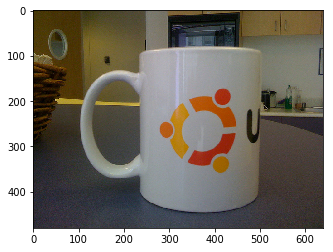

In [33]:
image = cv2.imread("cup.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

### Normalise
Image data typically has values 0..255 so we can convert these easily to the range 0..1. This is performed across all channels, regardless of the actual range of pixel values that are present in the image.

As we might not see all intensities we might need to consider min / max rather then just dividing by 255 to get a true target range of 0..1.

Min: 0.000, Max: 240.000
Min: 0.000, Max: 0.941


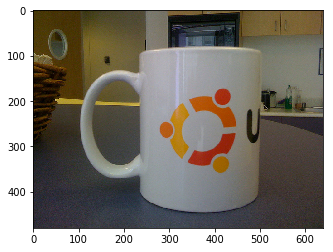

In [34]:
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (image.min(), image.max()))

# convert from integers to floats
image_scaled = image.astype('float32')

# normalize to the range 0-1
image_scaled /= 255.0

# confirm the normalization
print('Min: %.3f, Max: %.3f' % (image_scaled.min(), image_scaled.max()))

plt.imshow(image_scaled)
plt.show()

### Centering
Centering subtracts the mean value from the pixel valuesmeaning teh resulting distribution of the pixel values is centered on the value of zero.

Centering can be performed before or after normalization. Centering the pixels then normalizing will mean that the pixel values will be centered close to 0.5 and be in the range 0-1. Centering after normalization will mean that the pixels will have positive and negative values, in which case images will not display correctly (e.g. pixels are expected to have value in the range 0-255 or 0-1). 

Centering requires that a mean pixel value be calculated prior to subtracting it from the pixel values. There are multiple ways that the mean can be calculated; for example:

* Per image.
* Per mini-batch of images (under stochastic gradient descent).
* Per training dataset.

The mean can be calculated for all pixels in the image, referred to as a global centering, or it can be calculated for each channel in the case of color images, referred to as local centering.

#### Global Centering
Calculating and subtracting the mean pixel value across color channels.

In [24]:
# convert from integers to floats
image_scaled = image.astype('float32')
# calculate global mean
mean = image_scaled.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (image_scaled.min(), image_scaled.max()))
# global centering of pixels
image_scaled = image_scaled - mean
# confirm it had the desired effect
mean = image_scaled.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (image_scaled.min(), image_scaled.max()))

Mean: 90.124
Min: 0.000, Max: 240.000
Mean: 0.000
Min: -90.124, Max: 149.876


#### Local Centering
Calculating and subtracting the mean pixel value per color channel.

In [25]:
# convert from integers to floats
image_scaled = image.astype('float32')
# calculate per-channel means and standard deviations
means = image_scaled.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (image_scaled.min(axis=(0,1)), image_scaled.max(axis=(0,1))))
# per-channel centering of pixels
image_scaled -= means
# confirm it had the desired effect
means = image_scaled.mean(axis=(0,1), dtype='float64')
print('Means: %s' % means)
print('Mins: %s, Maxs: %s' % (image_scaled.min(axis=(0,1)), image_scaled.max(axis=(0,1))))

Means: [79.80314453 91.68438477 98.8833724 ]
Mins: [0. 0. 0.], Maxs: [226. 235. 240.]
Means: [-9.79758382e-07  2.17471388e-07 -2.22697466e-07]
Mins: [-79.80315 -91.68439 -98.88337], Maxs: [146.19685 143.31561 141.11662]


### Standardization
The distribution of pixel values often follows a Normal or Gaussian distribution. This distribution may be present per image, per mini-batch of images, or across the training dataset and globally or per channel.

As such, there may be benefit in transforming the distribution of pixel values to be a standard Gaussian: that is both centering the pixel values on zero and normalizing the values by the standard deviation. The result is a standard Gaussian of pixel values with a mean of 0.0 and a standard deviation of 1.0.

As with centering, the operation can be performed per image, per mini-batch, and across the entire training dataset, and it can be performed globally across channels or locally per channel.

Standardization may be preferred to normalization and centering alone and it results in both zero-centered values of small input values, roughly in the range -3 to 3, depending on the specifics of the dataset.

For consistency of the input data, it may make more sense to standardize images per-channel using statistics calculated per mini-batch or across the training dataset, if possible.

#### Global Standardization
The example below calculates the mean and standard deviation across all color channels in the loaded image, then uses these values to standardize the pixel values.

In [37]:
# convert from integers to floats
image_scaled = image.astype('float32')
# calculate global mean and standard deviation
mean, std = image_scaled.mean(), image_scaled.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of pixels
image_scaled = (image_scaled - mean) / std
# confirm it had the desired effect
mean, std = image_scaled.mean(), image_scaled.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))

Mean: 90.124, Standard Deviation: 47.233
Mean: 0.000, Standard Deviation: 1.000


There may also be a desire to maintain the pixel values in the positive domain, perhaps so the images can be visualized or perhaps for the benefit of a chosen activation function in the model. 

A popular way of achieving this is to clip the standardized pixel values to the range [-1, 1] and then rescale the values from [-1,1] to [0,1].

The example below updates the global standardization example to demonstrate this additional rescaling.

In [38]:
# clip pixel values to [-1,1]
image_scaled = clip(image_scaled, -1.0, 1.0)
# shift from [-1,1] to [0,1] with 0.5 mean
image_scaled = (image_scaled + 1.0) / 2.0
# confirm it had the desired effect
mean, std = image_scaled.mean(), image_scaled.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (image_scaled.min(), image_scaled.max()))

Mean: 0.479, Standard Deviation: 0.389
Min: 0.000, Max: 1.000


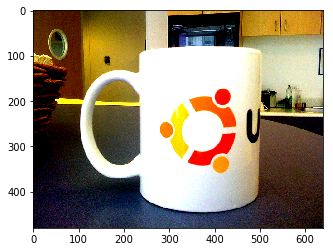

In [39]:
plt.imshow(image_scaled)
plt.show()

#### Local Standardization
The example below calculates the mean and standard deviation of the loaded image per-channel, then uses these statistics to standardize the pixels separately in each channel.

In [36]:
# convert from integers to floats
image_scaled = image.astype('float32')
# calculate per-channel means and standard deviations
means = image_scaled.mean(axis=(0,1), dtype='float64')
stds = image_scaled.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))
# per-channel standardization of pixels
image_scaled = (image_scaled - means) / stds
# confirm it had the desired effect
means = image_scaled.mean(axis=(0,1), dtype='float64')
stds = image_scaled.std(axis=(0,1), dtype='float64')
print('Means: %s, Stds: %s' % (means, stds))

Means: [98.8833724  91.68438477 79.80314453], Stds: [44.56136816 44.14615116 50.72041264]
Means: [-4.77050445e-14 -2.42293844e-14  1.81284602e-15], Stds: [1. 1. 1.]


## Evaluation of some different methods
Test training of a neural network with some different methods to see how they affect accuracy rates.

In [2]:
# normalize images
def prep_normalize(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# center images
def prep_center(train, test):
    # convert from integers to floats
    train_cent = train.astype('float32')
    test_cent = test.astype('float32')
    # calculate statistics
    m = train_cent.mean()
    # center datasets
    train_cent = train_cent - m
    test_cent = test_cent - m
    # return normalized images
    return train_cent, test_cent

# standardize images
def prep_standardize(train, test):
    # convert from integers to floats
    train_stan = train.astype('float32')
    test_stan = test.astype('float32')
    # calculate statistics
    m = train_stan.mean()
    s = train_stan.std()
    # center datasets
    train_stan = (train_stan - m) / s
    test_stan = (test_stan - m) / s
    # return normalized images
    return train_stan, test_stan

In [3]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    width, height, channels = trainX.shape[1], trainX.shape[2], 1
    trainX = trainX.reshape((trainX.shape[0], width, height, channels))
    testX = testX.reshape((testX.shape[0], width, height, channels))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# repeated evaluation of model with data prep scheme
def repeated_evaluation(datapre_func, n_repeats=10):
    # prepare data
    trainX, trainY, testX, testY = load_dataset()
    prep_trainX, prep_testX = datapre_func(trainX, testX)

    # statistics
    print('Train min(%.3f), max(%.3f), mean(%.3f), std(%.3f)' % 
          (prep_trainX.min(), prep_trainX.max(), prep_trainX.mean(), prep_trainX.std()))
    print('Test min(%.3f), max(%.3f), mean(%.3f), std(%.3f)' % 
          (prep_testX.min(), prep_testX.max(), prep_testX.mean(), prep_testX.std()))

    # repeated evaluation
    scores = list()
    for i in range(n_repeats):
        # define model
        model = define_model()
        # fit model
        model.fit(prep_trainX, trainY, epochs=5, batch_size=64, verbose=0)
        # evaluate model
        _, acc = model.evaluate(prep_testX, testY, verbose=0)
        # store result
        scores.append(acc)
        print('> %d: %.3f' % (i, acc * 100.0))
    print('Scores: %.3f (%.3f)' % (mean(scores), std(scores)))
    return scores

In [5]:
all_scores = list()
# normalization
print("Normalization")
scores = repeated_evaluation(prep_normalize)
all_scores.append(scores)

Normalization
Train min(0.000), max(1.000), mean(0.131), std(0.308)
Test min(0.000), max(1.000), mean(0.133), std(0.310)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
> 0: 99.060
> 1: 98.820
> 2: 99.040
> 3: 98.970
> 4: 99.120
> 5: 98.870
> 6: 98.840
> 7: 99.080
> 8: 98.980
> 9: 98.950
Scores: 0.990 (0.001)


In [6]:
# center
print("Centered")
scores = repeated_evaluation(prep_center)
all_scores.append(scores)

Centered
Train min(-33.318), max(221.682), mean(-0.000), std(78.567)
Test min(-33.318), max(221.682), mean(0.473), std(79.172)
> 0: 98.520
> 1: 98.520
> 2: 9.820
> 3: 98.630
> 4: 98.060
> 5: 98.250
> 6: 10.280
> 7: 9.800
> 8: 98.690
> 9: 8.920
Scores: 0.629 (0.435)


In [7]:
# standardize
print("Standardized")
scores = repeated_evaluation(prep_standardize)
all_scores.append(scores)

Standardized
Train min(-0.424), max(2.822), mean(-0.000), std(1.000)
Test min(-0.424), max(2.822), mean(0.006), std(1.008)
> 0: 98.930
> 1: 99.080
> 2: 99.040
> 3: 99.050
> 4: 98.830
> 5: 98.940
> 6: 99.160
> 7: 98.940
> 8: 98.970
> 9: 99.220
Scores: 0.990 (0.001)


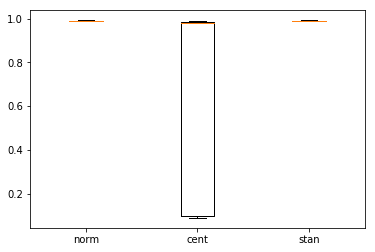

In [8]:
# box and whisker plots of results
plt.boxplot(all_scores, labels=['norm', 'cent', 'stan'])
plt.show()

From the above scores and plot we can see that normalisation and standardisation on this data set at least have a pretty similar result. We would probably thus use normalisation as it is simpler. Centering has some outliers that affect the results.